In [1]:
import json

import numpy as np

from pathlib import Path

from overcast import models
from overcast import datasets
from overcast.models import ensembles
from overcast.visualization import plotting

In [2]:
experiment_dir = Path("../../output/")
experiment_dir = experiment_dir / "dose-response_n-1000_gt-0.3_gy-0.5_seed-0"
experiment_dir = experiment_dir / "appended-treatment-nn"
experiment_dir = experiment_dir / "dh-96_nco-24_nct-24_dp-3_ns-0.05_bt-0.0_ln-False_dr-0.04_sn-0.0_lr-0.0015_bs-32_ep-300"
config_path = experiment_dir / "config.json"
checkpoint_dir = experiment_dir = experiment_dir / "checkpoints"

In [3]:
with open(config_path) as cp:
    config = json.load(cp)

In [4]:
dataset_name = config.get("dataset_name")
dataset_name = "dose-response"
num_components_outcome = config.get("num_components_outcome")
num_components_treatment = config.get("num_components_treatment")
dim_hidden = config.get("dim_hidden")
depth = config.get("depth")
negative_slope = config.get("negative_slope")
beta = config.get("beta")
layer_norm = config.get("layer_norm")
dropout_rate = config.get("dropout_rate")
spectral_norm = config.get("spectral_norm")
learning_rate = config.get("learning_rate")
batch_size = config.get("batch_size")
epochs = config.get("epochs")
ensemble_size = config.get("ensemble_size")

In [5]:
ds = {
    "test": datasets.DATASETS.get(dataset_name)(**config.get("ds_test")),
    "valid": datasets.DATASETS.get(dataset_name)(**config.get("ds_valid")),
    "train": datasets.DATASETS.get(dataset_name)(**config.get("ds_train")),
}

In [6]:
ensemble = []
for ensemble_id in range(ensemble_size):
    model_dir = checkpoint_dir / f"model-{ensemble_id}" / "mu"
    model = models.AppendedTreatmentNeuralNetwork(
        job_dir=model_dir,
        architecture="resnet",
        dim_input=ds["train"].dim_input,
        dim_treatment=ds["train"].dim_treatments,
        dim_output=ds["train"].dim_targets,
        num_components_outcome=num_components_outcome,
        num_components_treatment=num_components_treatment,
        dim_hidden=dim_hidden,
        depth=depth,
        negative_slope=negative_slope,
        beta=beta,
        layer_norm=layer_norm,
        spectral_norm=spectral_norm,
        dropout_rate=dropout_rate,
        num_examples=len(ds["train"]),
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs,
        patience=epochs,
        num_workers=0,
        seed=ensemble_id,
    )
    model.load()
    ensemble.append(model)

2022-05-26 10:16:37,531 overcast.models.core.AppendedTreatmentNeuralNetwork INFO: Loading saved checkpoint ../../output/dose-response_n-1000_gt-0.3_gy-0.5_seed-0/appended-treatment-nn/dh-96_nco-24_nct-24_dp-3_ns-0.05_bt-0.0_ln-False_dr-0.04_sn-0.0_lr-0.0015_bs-32_ep-300/checkpoints/model-0/mu/best_checkpoint.pt
2022-05-26 10:16:37,623 overcast.models.core.AppendedTreatmentNeuralNetwork INFO: Loading saved checkpoint ../../output/dose-response_n-1000_gt-0.3_gy-0.5_seed-0/appended-treatment-nn/dh-96_nco-24_nct-24_dp-3_ns-0.05_bt-0.0_ln-False_dr-0.04_sn-0.0_lr-0.0015_bs-32_ep-300/checkpoints/model-0/mu/best_checkpoint.pt
2022-05-26 10:16:37,642 overcast.models.core.AppendedTreatmentNeuralNetwork INFO: Loading saved checkpoint ../../output/dose-response_n-1000_gt-0.3_gy-0.5_seed-0/appended-treatment-nn/dh-96_nco-24_nct-24_dp-3_ns-0.05_bt-0.0_ln-False_dr-0.04_sn-0.0_lr-0.0015_bs-32_ep-300/checkpoints/model-1/mu/best_checkpoint.pt
2022-05-26 10:16:37,760 overcast.models.core.AppendedTreatmen

In [8]:
idx_output = 0
treatments = np.arange(ds["train"].treatments.min(), ds["train"].treatments.max(), 0.01)
capos_ensemble = ensembles.predict_capos(
    ensemble=ensemble, 
    dataset=ds["test"], 
    treatments=treatments, 
    batch_size=5000,
)

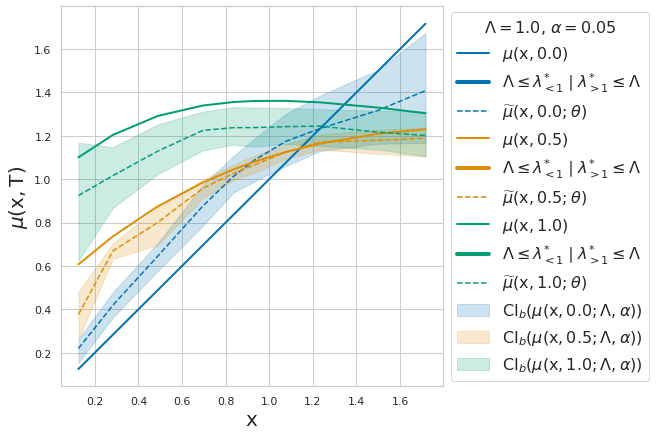

In [9]:
_ = plotting.capo_curves(
    dataset=ds["test"],
    treatments=treatments,
    capos=capos_ensemble[idx_output],
    upper_capos=capos_ensemble[idx_output],
    lower_capos=capos_ensemble[idx_output],
    treatment_indices=[0, 49, 99],
    lambda_=1.0,
    alpha=0.05,
    figsize=(9, 6),
    plot_legend=True,
)

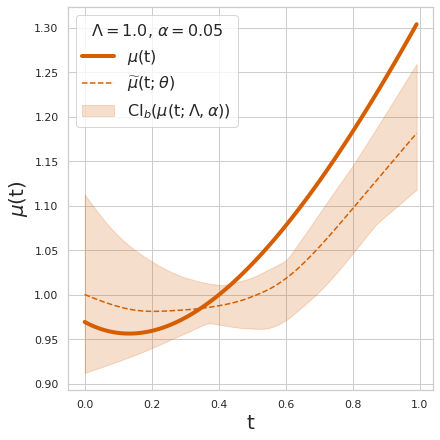

In [10]:
_ = plotting.apo_curve(
    dataset=ds["test"],
    treatments=treatments,
    capos=capos_ensemble[idx_output],
    upper_capos=capos_ensemble[idx_output],
    lower_capos=capos_ensemble[idx_output],
    lambda_=1.0,
    alpha=0.05,
    figsize=(6, 6),
    linewidth=4.0,
    xlim=None,
    ylim=None,
    save_path=None,
)

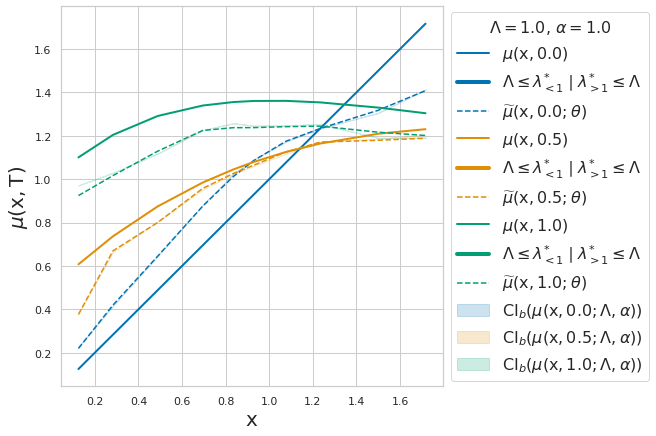

In [11]:
_ = plotting.capo_curves(
    dataset=ds["test"],
    treatments=treatments,
    capos=capos_ensemble[idx_output],
    upper_capos=capos_ensemble[idx_output],
    lower_capos=capos_ensemble[idx_output],
    treatment_indices=[0, 49, 99],
    lambda_=1.0,
    alpha=1.0,
    figsize=(9, 6),
    plot_legend=True,
)

In [12]:
log_lambda = 0.1
lower_capos_1, upper_capos_1 = ensembles.predict_intervals(
    ensemble=ensemble,
    dataset=ds["test"],
    treatments=treatments,
    log_lambda=log_lambda,
    num_samples=100,
    batch_size=5000,
)

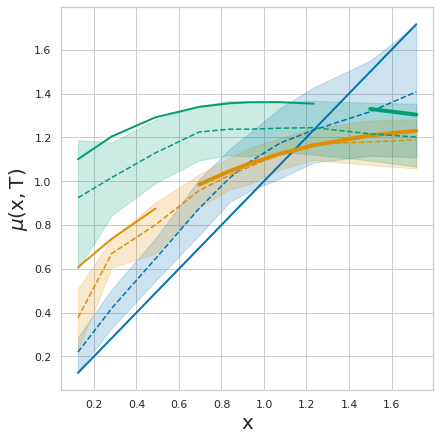

In [13]:
_ = plotting.capo_curves(
    dataset=ds["test"],
    treatments=treatments,
    capos=capos_ensemble[idx_output],
    lower_capos=lower_capos_1[idx_output],
    upper_capos=upper_capos_1[idx_output],
    treatment_indices=[0, 49, 99],
    lambda_=np.exp(0.1),
    alpha=0.05,
    figsize=(6, 6),
    plot_legend=False,
)

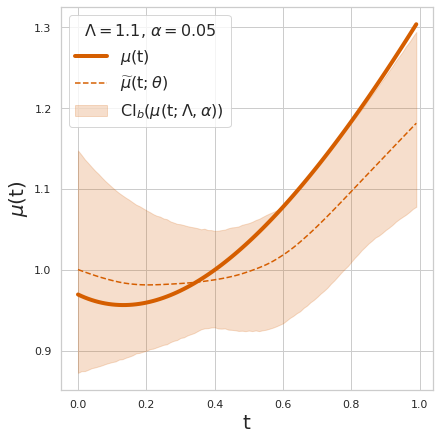

In [14]:
_ = plotting.apo_curve(
    dataset=ds["test"],
    treatments=treatments,
    capos=capos_ensemble[idx_output],
    lower_capos=lower_capos_1[idx_output],
    upper_capos=upper_capos_1[idx_output],
    lambda_=np.exp(0.1),
    alpha=0.05,
    figsize=(6, 6),
    linewidth=4.0,
    xlim=None,
    ylim=None,
    save_path=None,
)

In [15]:
log_lambda = 0.2
lower_capos_2, upper_capos_2 = ensembles.predict_intervals(
    ensemble=ensemble,
    dataset=ds["test"],
    treatments=treatments,
    log_lambda=log_lambda,
    num_samples=100,
    batch_size=5000,
)

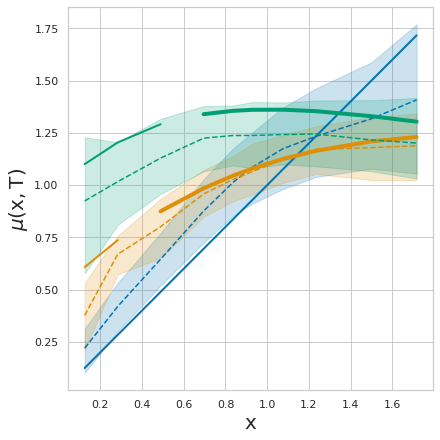

In [16]:
_ = plotting.capo_curves(
    dataset=ds["test"],
    treatments=treatments,
    capos=capos_ensemble[idx_output],
    lower_capos=lower_capos_2[idx_output],
    upper_capos=upper_capos_2[idx_output],
    treatment_indices=[0, 49, 99],
    lambda_=np.exp(0.2),
    alpha=0.05,
    figsize=(6, 6),
    plot_legend=False,
)

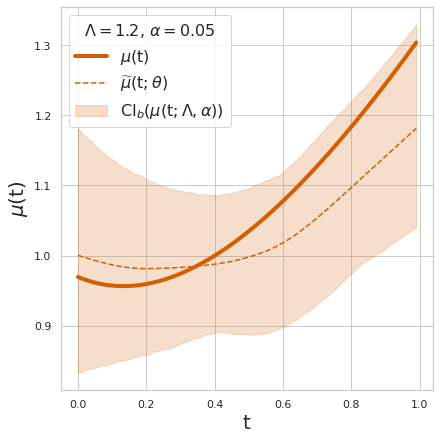

In [17]:
_ = plotting.apo_curve(
    dataset=ds["test"],
    treatments=treatments,
    capos=capos_ensemble[idx_output],
    lower_capos=lower_capos_2[idx_output],
    upper_capos=upper_capos_2[idx_output],
    lambda_=np.exp(0.2),
    alpha=0.05,
    figsize=(6, 6),
    linewidth=4.0,
    xlim=None,
    ylim=None,
    save_path=None,
)

In [18]:
log_lambda = 0.5
lower_capos_3, upper_capos_3 = ensembles.predict_intervals(
    ensemble=ensemble,
    dataset=ds["test"],
    treatments=treatments,
    log_lambda=log_lambda,
    num_samples=100,
    batch_size=5000,
)

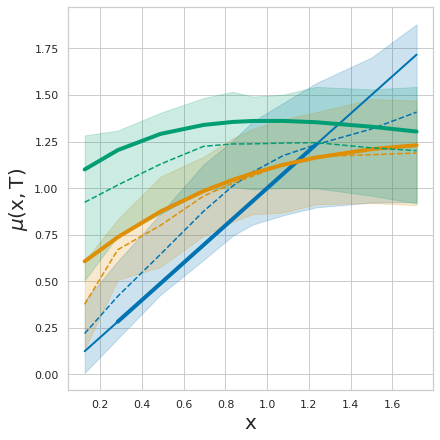

In [19]:
_ = plotting.capo_curves(
    dataset=ds["test"],
    treatments=treatments,
    capos=capos_ensemble[idx_output],
    lower_capos=lower_capos_3[idx_output],
    upper_capos=upper_capos_3[idx_output],
    treatment_indices=[0, 49, 99],
    lambda_=np.exp(0.5),
    alpha=0.05,
    figsize=(6, 6),
    plot_legend=False,
)

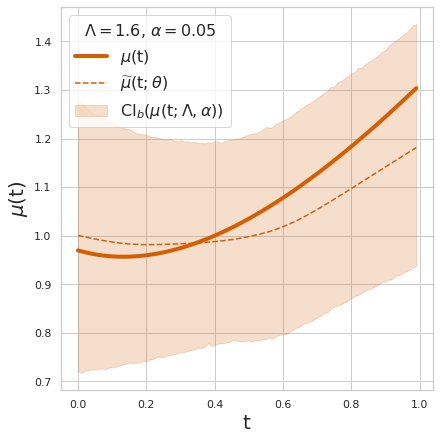

In [20]:
_ = plotting.apo_curve(
    dataset=ds["test"],
    treatments=treatments,
    capos=capos_ensemble[idx_output],
    lower_capos=lower_capos_3[idx_output],
    upper_capos=upper_capos_3[idx_output],
    lambda_=np.exp(0.5),
    alpha=0.05,
    figsize=(6, 6),
    linewidth=4.0,
    xlim=None,
    ylim=None,
    save_path=None,
)